In [1]:

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Define file paths
meta_cds_path = r"D:\Desktop Codes Data\Data Science\Developement\ipynb files\Sales_Forcast_Project\Developement\Data Domains Analysis\meta_CDs_and_Vinyl Domain\final_df.csv"
software_path = r"D:\Desktop Codes Data\Data Science\Developement\ipynb files\Sales_Forcast_Project\Developement\Data Domains Analysis\Software Domain\final_df.csv"

In [2]:
# 2. Data Loading Function
def load_and_preprocess_data(file_path):
    """Load data from CSV and perform initial preprocessing"""
    print(f"Loading data from {os.path.basename(file_path)}...")
    df = pd.read_csv(file_path)
    
    # Remove unnamed index column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Convert timestamp to datetime format for proper sorting
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort by timestamp and reset index
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Ensure price > 0 for log calculation
    df = df[df['price'] > 0].copy()
    
    # Create log_price
    df['log_price'] = np.log(df['price'])
    
    return df

# Load and preprocess data immediately after function definition
cds_df = load_and_preprocess_data(meta_cds_path)
software_df = load_and_preprocess_data(software_path)

# Add domain identifier columns
cds_df['domain'] = 'CDs_and_Vinyl'
software_df['domain'] = 'Software'

# Combine datasets
combined_df = pd.concat([cds_df, software_df], ignore_index=True)
print(f"\nCombined dataset shape: {combined_df.shape}")

Loading data from final_df.csv...
Loading data from final_df.csv...

Combined dataset shape: (4901446, 9)


In [3]:
# 2. Data Loading Function
def load_and_preprocess_data(file_path):
    """Load data from CSV and perform initial preprocessing"""
    print(f"Loading data from {os.path.basename(file_path)}...")
    df = pd.read_csv(file_path)
    
    # Remove unnamed index column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Convert timestamp to datetime format for proper sorting
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort by timestamp and reset index
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Ensure price > 0 for log calculation
    df = df[df['price'] > 0].copy()
    
    # Create log_price
    df['log_price'] = np.log(df['price'])
    
    return df

# Load and preprocess data immediately after function definition
cds_df = load_and_preprocess_data(meta_cds_path)
software_df = load_and_preprocess_data(software_path)

# Add domain identifier columns
cds_df['domain'] = 'CDs_and_Vinyl'
software_df['domain'] = 'Software'

# Combine datasets
combined_df = pd.concat([cds_df, software_df], ignore_index=True)
print(f"\nCombined dataset shape: {combined_df.shape}")

Loading data from final_df.csv...
Loading data from final_df.csv...

Combined dataset shape: (4901446, 9)


In [4]:
# 3. MAD Score Calculation
def calculate_mad_scores(df, numerical_cols):
    """Calculate Median Absolute Deviation scores for numerical columns"""
    mad_scores = {}
    for col in numerical_cols:
        # Calculate median
        median = df[col].median()
        # Calculate absolute deviations
        abs_dev = np.abs(df[col] - median)
        # Calculate MAD (Median Absolute Deviation)
        mad = np.median(abs_dev)
        # Calculate MAD scores (avoiding division by zero)
        if mad > 0:
            mad_scores[col] = abs_dev / mad
        else:
            mad_scores[col] = abs_dev  # If MAD is 0, just use absolute deviations
    return mad_scores

# Define numerical columns for outlier detection
numerical_cols = ['log_price']

# Calculate MAD scores for each dataset
print("\nCalculating MAD scores...")
cds_mad_scores = calculate_mad_scores(cds_df, numerical_cols)
software_mad_scores = calculate_mad_scores(software_df, numerical_cols)
combined_mad_scores = calculate_mad_scores(combined_df, numerical_cols)


Calculating MAD scores...


In [5]:
# 4. Outlier Detection and Removal
def detect_and_remove_outliers(df, mad_scores, threshold=3.5):
    """Detect and remove outliers based on MAD score threshold"""
    # Create a mask for all outliers across all columns
    outlier_mask = pd.Series(False, index=df.index)
    
    for col, scores in mad_scores.items():
        # Ensure scores don't include NaNs
        scores = scores.fillna(0)
        col_outliers = scores > threshold
        outlier_mask = outlier_mask | col_outliers
    
    print(f"Detected {outlier_mask.sum()} outliers out of {len(df)} records ({outlier_mask.sum()/len(df)*100:.2f}%)")
    # Return DataFrame without outliers and the outliers
    return df[~outlier_mask], df[outlier_mask]

# Detect and remove outliers for each dataset
print("\nDetecting outliers in CDs dataset...")
cds_clean_df, cds_outliers_df = detect_and_remove_outliers(cds_df, cds_mad_scores)

print("\nDetecting outliers in Software dataset...")
software_clean_df, software_outliers_df = detect_and_remove_outliers(software_df, software_mad_scores)

print("\nDetecting outliers in Combined dataset...")
combined_clean_df, combined_outliers_df = detect_and_remove_outliers(combined_df, combined_mad_scores)


Detecting outliers in CDs dataset...
Detected 330790 outliers out of 4324655 records (7.65%)

Detecting outliers in Software dataset...
Detected 41794 outliers out of 576791 records (7.25%)

Detecting outliers in Combined dataset...
Detected 506716 outliers out of 4901446 records (10.34%)



Plotting distributions...


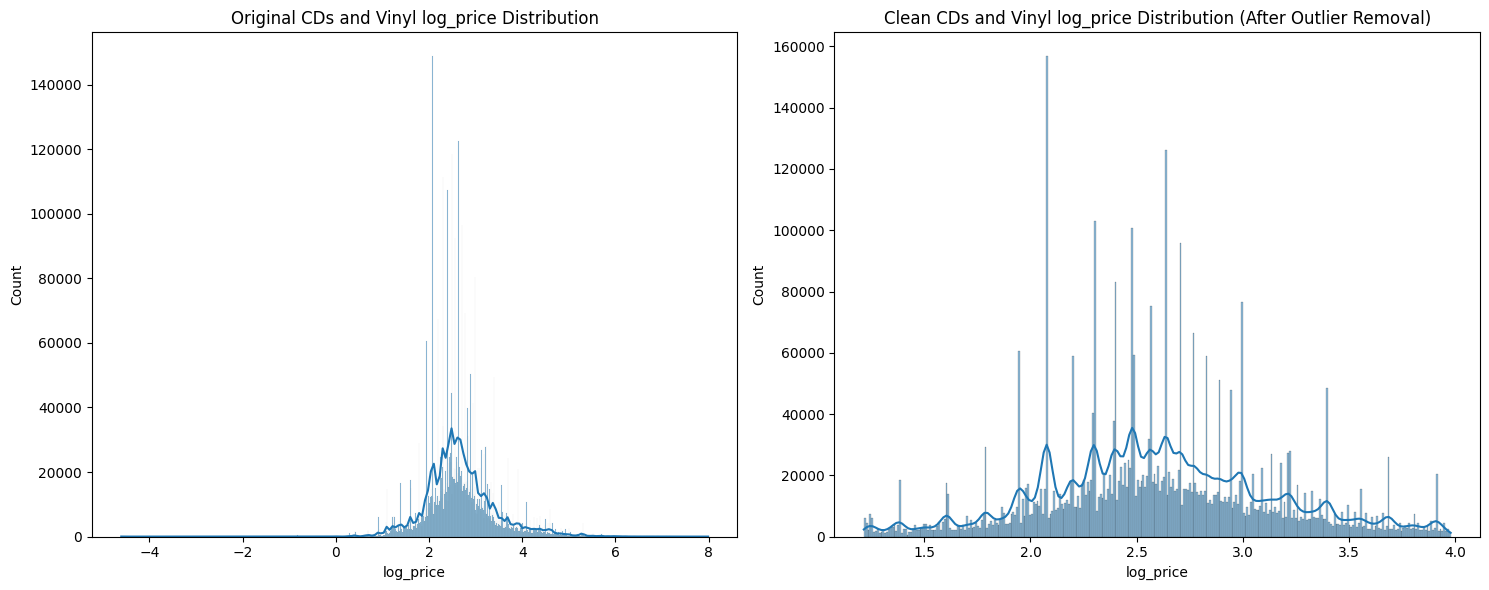

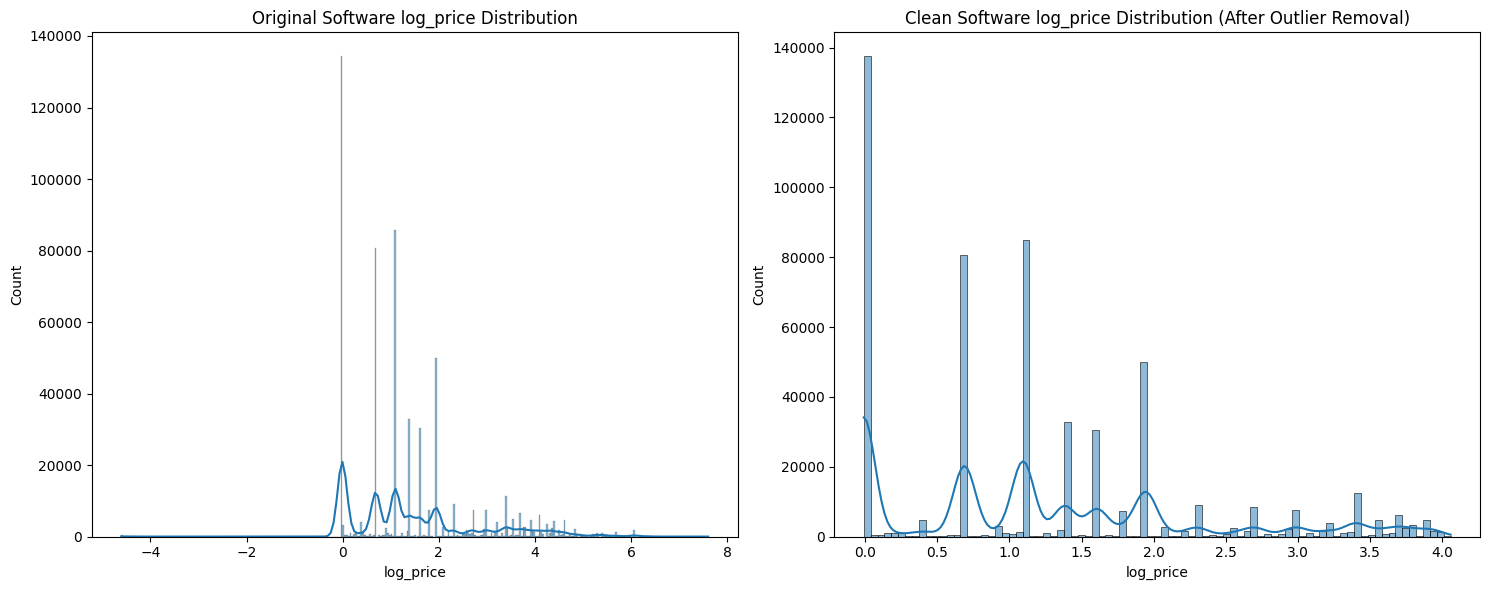

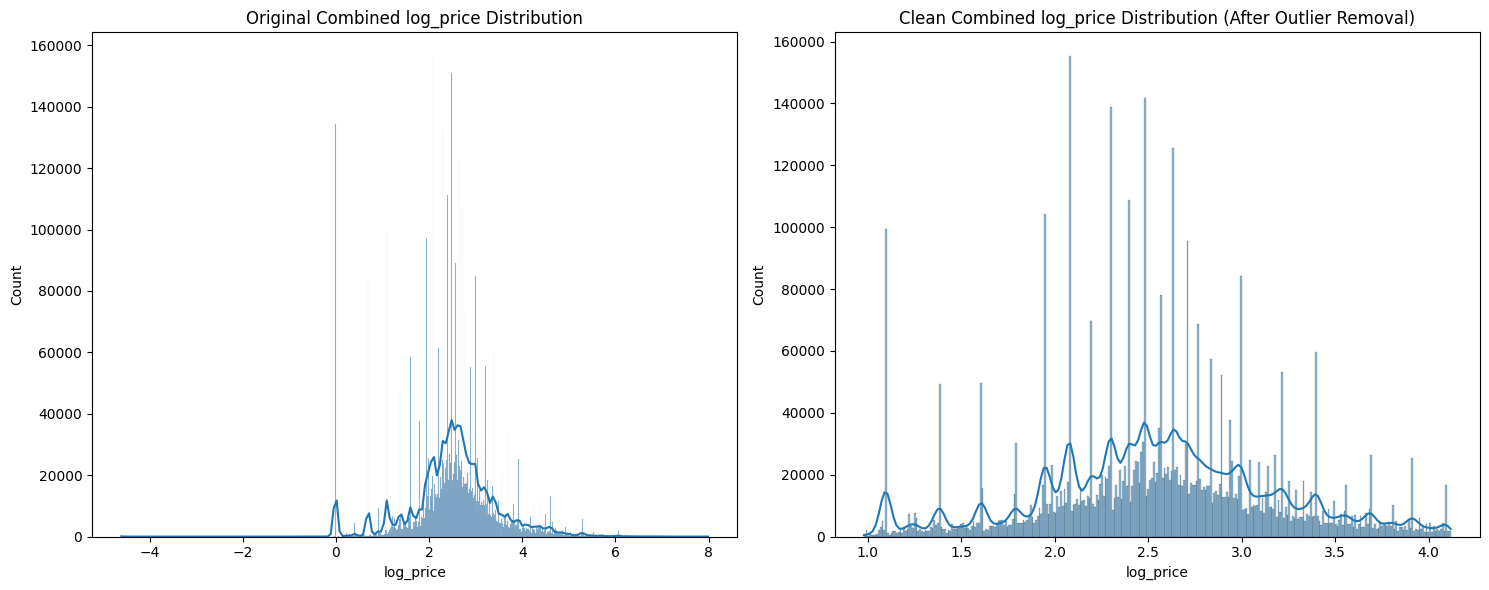

In [6]:
# 5. Distribution Plotting
def plot_distributions(df_original, df_clean, column, title):
    """Plot distribution before and after outlier removal"""
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_original[column], kde=True)
    plt.title(f"Original {title} Distribution")
    plt.xlabel(column)
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean[column], kde=True)
    plt.title(f"Clean {title} Distribution (After Outlier Removal)")
    plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()

# Plot distributions for each dataset
print("\nPlotting distributions...")
for col in numerical_cols:
    plot_distributions(cds_df, cds_clean_df, col, f"CDs and Vinyl {col}")
    plot_distributions(software_df, software_clean_df, col, f"Software {col}")
    plot_distributions(combined_df, combined_clean_df, col, f"Combined {col}")

In [7]:
# 6. Iterative Outlier Removal
def remove_outliers_iteratively(df, numerical_cols, threshold=3.5, max_iterations=5):
    """Remove outliers iteratively until no more are found or max iterations reached"""
    iteration = 1
    outliers_removed = 0
    df_clean = df.copy()
    all_outliers = pd.DataFrame()
    
    while iteration <= max_iterations:
        print(f"\nIteration {iteration}:")
        
        # Calculate MAD scores
        mad_scores = calculate_mad_scores(df_clean, numerical_cols)
        
        # Detect and remove outliers
        new_df_clean, iteration_outliers = detect_and_remove_outliers(df_clean, mad_scores, threshold)
        
        # Track outliers
        if len(iteration_outliers) > 0:
            all_outliers = pd.concat([all_outliers, iteration_outliers])
            outliers_removed += len(iteration_outliers)
        
        # Check if we found any outliers
        if len(iteration_outliers) == 0:
            print(f"No more outliers found after {iteration} iterations.")
            break
        
        # Update clean dataframe
        df_clean = new_df_clean
        iteration += 1
    
    print(f"\nTotal outliers removed: {outliers_removed} ({outliers_removed/len(df)*100:.2f}%)")
    return df_clean, all_outliers

# Use iterative outlier removal on each dataset
print("\n--- Iterative Processing: CDs and Vinyl Dataset ---")
cds_iter_clean_df, cds_iter_outliers = remove_outliers_iteratively(cds_df, numerical_cols)

print("\n--- Iterative Processing: Software Dataset ---")
software_iter_clean_df, software_iter_outliers = remove_outliers_iteratively(software_df, numerical_cols)

print("\n--- Iterative Processing: Combined Dataset ---")
combined_iter_clean_df, combined_iter_outliers = remove_outliers_iteratively(combined_df, numerical_cols)


--- Iterative Processing: CDs and Vinyl Dataset ---

Iteration 1:
Detected 330790 outliers out of 4324655 records (7.65%)

Iteration 2:
Detected 130395 outliers out of 3993865 records (3.26%)

Iteration 3:
Detected 63197 outliers out of 3863470 records (1.64%)

Iteration 4:
Detected 3044 outliers out of 3800273 records (0.08%)

Iteration 5:
Detected 0 outliers out of 3797229 records (0.00%)
No more outliers found after 5 iterations.

Total outliers removed: 527426 (12.20%)

--- Iterative Processing: Software Dataset ---

Iteration 1:
Detected 41794 outliers out of 576791 records (7.25%)

Iteration 2:
Detected 0 outliers out of 534997 records (0.00%)
No more outliers found after 2 iterations.

Total outliers removed: 41794 (7.25%)

--- Iterative Processing: Combined Dataset ---

Iteration 1:
Detected 506716 outliers out of 4901446 records (10.34%)

Iteration 2:
Detected 201395 outliers out of 4394730 records (4.58%)

Iteration 3:
Detected 82865 outliers out of 4193335 records (1.98%)



In [8]:
# 7. Domain Comparison and general statistics
print("\n--- Domain Comparison (After Iterative Cleaning) ---")
domain_stats = combined_iter_clean_df.groupby('domain')['log_price'].agg(['mean', 'median', 'std', 'min', 'max']).round(3)
print(domain_stats)


--- Domain Comparison (After Iterative Cleaning) ---
                mean  median    std    min    max
domain                                           
CDs_and_Vinyl  2.582   2.563  0.506  1.306  3.819
Software       2.225   1.944  0.759  1.306  3.817


In [9]:
combined_iter_clean_df.head(10)

parent_asin        asin  rating           timestamp  \
0  B000000LWZ  B000000LWZ       5 1997-09-09 03:13:17   
1  B000002H3Z  B000002H3Z       5 1997-09-13 22:05:50   
2  B000003YSX  B000003YSX       5 1997-10-05 21:21:20   
3  B000002H2H  B000002H2H       5 1997-10-20 14:48:57   
4  B000002AS3  B000002AS3       5 1997-10-21 17:42:32   
5  B000005EAP  B000005EAP       5 1997-11-08 22:42:01   
6  B000002B6Z  B000002B6Z       5 1997-11-12 01:37:58   
7  B00000150Q  B00000150Q       5 1997-11-14 03:47:57   
8  B000002GP1  B000002GP1       5 1997-11-18 06:54:25   
9  B000005ALT  B000005ALT       5 1997-11-18 21:23:34   

                                                text  main_category  price  \
0  It was while driving on Highway 83, heading of...  Digital Music  10.98   
1  This isn't actually a book. It is a beautifull...  Digital Music  14.98   
2  This album is not of what one would usually re...  Digital Music  15.99   
3  Released on November 23 1984, Metallica's seco...  Digital Music   7.30   
4  This is the first cd made by Oasis. My favorit...  Digital Music   9.09   
5  As a world premier, this CD's creators were na...  Digital Music  31.90   
6  If you don't know Alice Cooper music, this is ...  Digital Music  11.95   
7  This Cd is very well put together and has a ni...  Digital Music  14.99   
8  &quot;Lock 'N Load&quot; is Denis Leary's seco...  Digital Music   7.77   
9  Yes, RENT IS the simply the best Musical out t...  Digital Music  15.99   

   log_price         domain  
0   2.396075  CDs_and_Vinyl  
1   2.706716  CDs_and_Vinyl  
2   2.771964  CDs_and_Vinyl  
3   1.987874  CDs_and_Vinyl  
4   2.207175  CDs_and_Vinyl  
5   3.462606  CDs_and_Vinyl  
6   2.480731  CDs_and_Vinyl  
7   2.707383  CDs_and_Vinyl  
8   2.050270  CDs_and_Vinyl  
9   2.771964  CDs_and_Vinyl

In [10]:
combined_iter_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4096696 entries, 0 to 4901445
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   parent_asin    object        
 1   asin           object        
 2   rating         int64         
 3   timestamp      datetime64[ns]
 4   text           object        
 5   main_category  object        
 6   price          float64       
 7   log_price      float64       
 8   domain         object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 312.6+ MB


In [11]:
combined_iter_clean_df.describe()

rating                      timestamp         price     log_price
count  4.096696e+06                        4096696  4.096696e+06  4.096696e+06
mean   4.476380e+00  2013-08-23 11:15:14.729145088  1.492738e+01  2.564354e+00
min    1.000000e+00            1997-09-09 03:13:17  3.690000e+00  1.305626e+00
25%    4.000000e+00     2009-11-24 02:11:55.500000  9.000000e+00  2.197225e+00
50%    5.000000e+00     2014-12-19 06:08:32.500000  1.295000e+01  2.561096e+00
75%    5.000000e+00  2017-08-12 15:28:28.801499904  1.842000e+01  2.913437e+00
max    5.000000e+00     2023-09-11 02:13:11.515000  4.556000e+01  3.819030e+00
std    1.037678e+00                            NaN  8.263724e+00  5.269582e-01

In [12]:
#skewness and kurtosi
print("\nSkewness and Kurtosis:")
skewness = combined_iter_clean_df['log_price'].skew()
kurtosis = combined_iter_clean_df['log_price'].kurtosis()
print(f"Skewness: {skewness:.3f}")
print(f"Kurtosis: {kurtosis:.3f}")
#they are in acceptable range of skewness and kurtosis


Skewness and Kurtosis:
Skewness: 0.045
Kurtosis: -0.307


In [13]:
# 8. Handle NaN Values
def handle_nan_values(df):
    """Remove or handle NaN values in the dataframe"""
    # Initial shape
    initial_shape = df.shape
    
    print("\n--- NaN Value Analysis ---")
    # Count NaN values in each column
    nan_counts = df.isna().sum()
    print("NaN values per column:")
    print(nan_counts[nan_counts > 0] if any(nan_counts > 0) else "No NaN values found in any column!")
    
    # Remove rows with any NaN values
    df_clean = df.dropna()
    
    # Report on changes
    rows_removed = initial_shape[0] - df_clean.shape[0]
    print(f"\nRows removed due to NaN values: {rows_removed} ({rows_removed/initial_shape[0]*100:.2f}%)")
    print(f"Final shape after NaN removal: {df_clean.shape}")
    
    # Basic statistics after NaN removal
    print("\nBasic statistics after NaN removal:")
    print(df_clean.describe().round(3))
    
    return df_clean

# Handle NaN values in the final dataset
final_clean_df = handle_nan_values(combined_iter_clean_df)

# Show first few rows of the final clean dataset
print("\n--- Final Clean Dataset Preview ---")
final_clean_df.head()




--- NaN Value Analysis ---
NaN values per column:
text    724
dtype: int64

Rows removed due to NaN values: 724 (0.02%)
Final shape after NaN removal: (4095972, 9)

Basic statistics after NaN removal:
            rating                      timestamp        price    log_price
count  4095972.000                        4095972  4095972.000  4095972.000
mean         4.476  2013-08-23 02:02:11.351879424       14.927        2.564
min          1.000            1997-09-09 03:13:17        3.690        1.306
25%          4.000            2009-11-23 19:06:02        9.000        2.197
50%          5.000     2014-12-19 01:04:14.500000       12.950        2.561
75%          5.000  2017-08-11 22:09:23.585499904       18.420        2.913
max          5.000     2023-09-11 02:13:11.515000       45.560        3.819
std          1.038                            NaN        8.264        0.527

--- Final Clean Dataset Preview ---


parent_asin        asin  rating           timestamp  \
0  B000000LWZ  B000000LWZ       5 1997-09-09 03:13:17   
1  B000002H3Z  B000002H3Z       5 1997-09-13 22:05:50   
2  B000003YSX  B000003YSX       5 1997-10-05 21:21:20   
3  B000002H2H  B000002H2H       5 1997-10-20 14:48:57   
4  B000002AS3  B000002AS3       5 1997-10-21 17:42:32   

                                                text  main_category  price  \
0  It was while driving on Highway 83, heading of...  Digital Music  10.98   
1  This isn't actually a book. It is a beautifull...  Digital Music  14.98   
2  This album is not of what one would usually re...  Digital Music  15.99   
3  Released on November 23 1984, Metallica's seco...  Digital Music   7.30   
4  This is the first cd made by Oasis. My favorit...  Digital Music   9.09   

   log_price         domain  
0   2.396075  CDs_and_Vinyl  
1   2.706716  CDs_and_Vinyl  
2   2.771964  CDs_and_Vinyl  
3   1.987874  CDs_and_Vinyl  
4   2.207175  CDs_and_Vinyl

In [14]:
# Domain distribution in final dataset
print("\n--- Domain Distribution in Final Dataset ---")
domain_counts = final_clean_df['domain'].value_counts()
print(domain_counts)
print(f"Domain percentages:\n{(domain_counts / len(final_clean_df) * 100).round(2)}%")

# Optional: Save the final clean dataset
# final_clean_df.to_csv('final_clean_df.csv', index=False)


--- Domain Distribution in Final Dataset ---
domain
CDs_and_Vinyl    3891474
Software          204498
Name: count, dtype: int64
Domain percentages:
domain
CDs_and_Vinyl    95.01
Software          4.99
Name: count, dtype: float64%


In [15]:
final_clean_df["main_category"].value_counts()

main_category
Digital Music                3789947
Appstore for Android          147282
Movies & TV                    69267
Software                       57220
Books                          30028
Tools & Home Improvement         497
Office Products                  455
Toys & Games                     331
Amazon Home                      203
Grocery                          148
Musical Instruments              147
All Beauty                        89
Cell Phones & Accessories         84
Industrial & Scientific           58
Health & Personal Care            43
AMAZON FASHION                    42
Sports & Outdoors                 41
All Electronics                   37
Video Games                       29
Arts, Crafts & Sewing             13
Home Audio & Theater               9
Pet Supplies                       1
Camera & Photo                     1
Name: count, dtype: int64


--- Sentiment Analysis on Text Data ---
Performing sentiment analysis on all 4095972 rows with text data
Using TextBlob for sentiment analysis


Analyzing sentiment: 100%|██████████| 4095972/4095972 [28:31<00:00, 2393.90it/s] 


Sentiment analysis completed for 4095972 texts

Sentiment Distribution:
sentiment_category
Positive    2468295
Neutral     1565385
Negative      62292
Name: count, dtype: int64
Percentages:
sentiment_category
Positive    60.26
Neutral     38.22
Negative     1.52
Name: count, dtype: float64%

Generating word clouds...


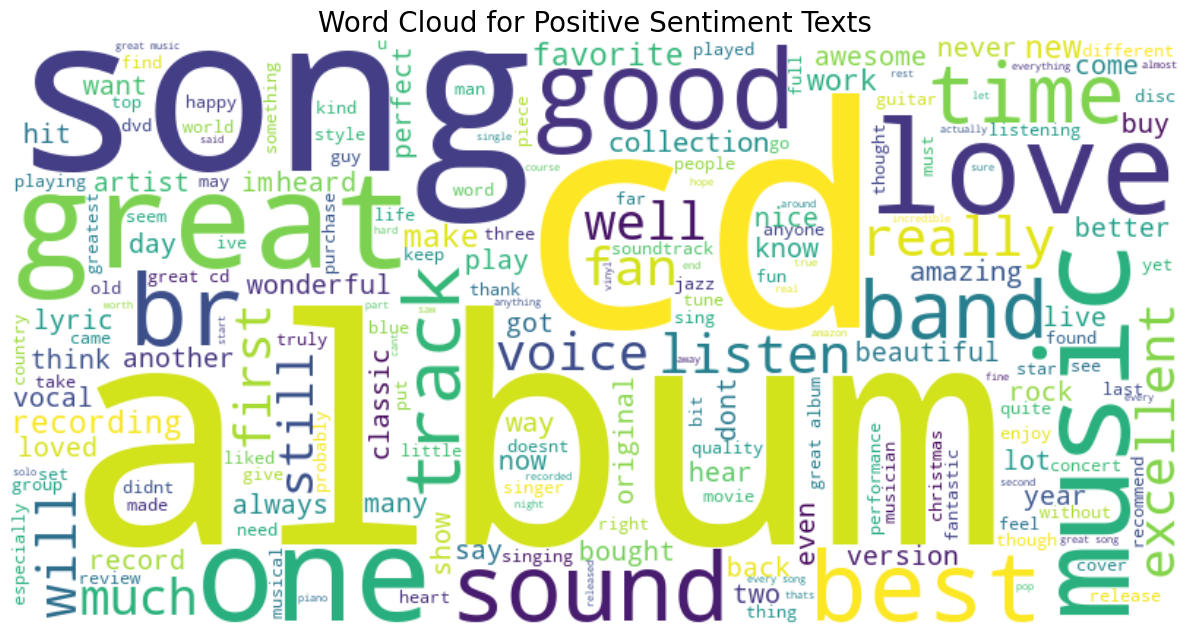

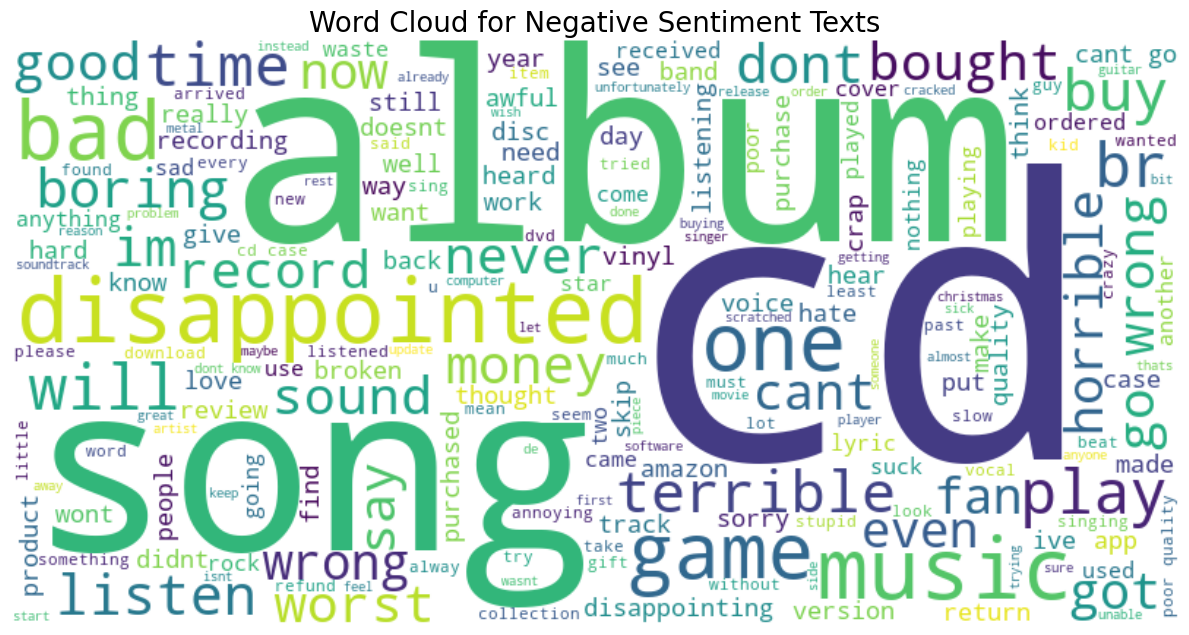


Sentiment Analysis by Domain:
                mean  median    count
domain                               
CDs_and_Vinyl  0.364   0.327  3891474
Software       0.204   0.178   204498


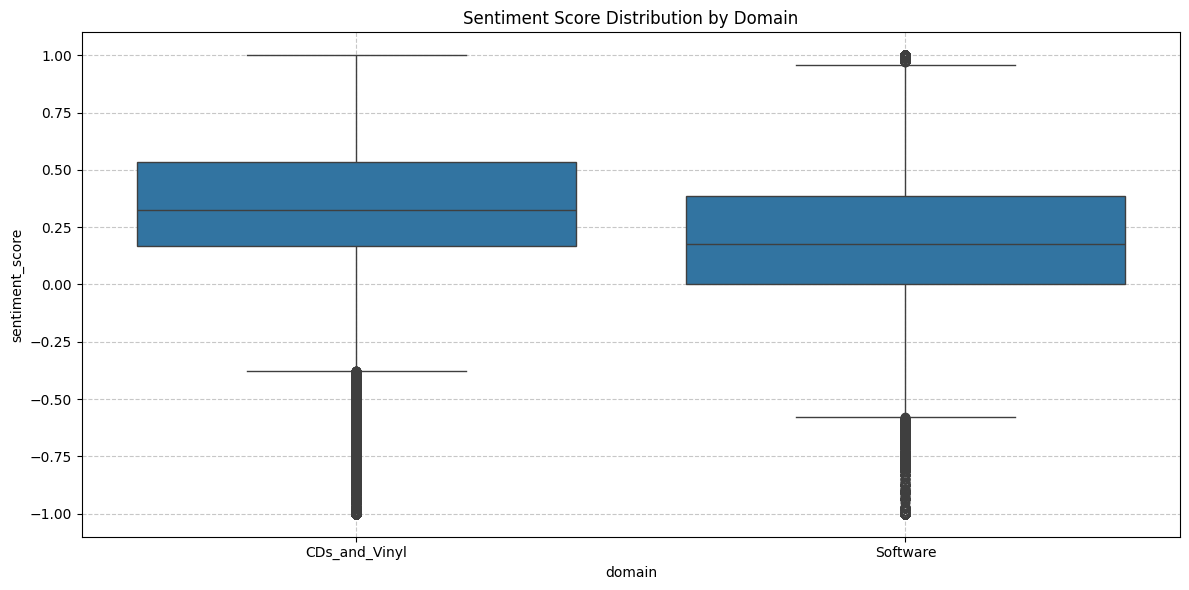


--- Correlation between Sentiment and Price ---
                 sentiment_score  log_price
sentiment_score         1.000000   0.004481
log_price               0.004481   1.000000


C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\2403557282.py:160: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Ahmed Mohamed\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


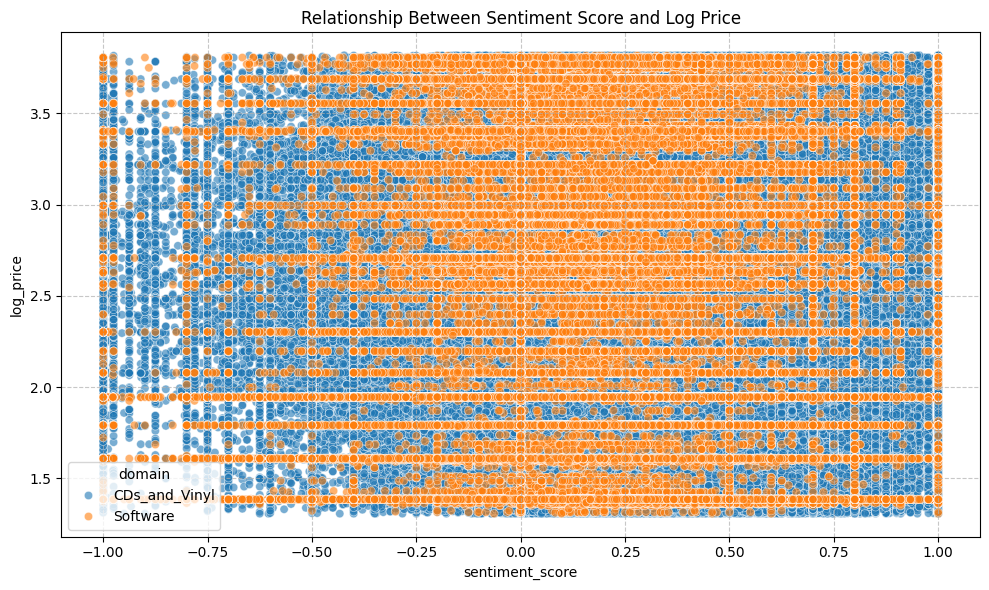

In [16]:
# 9. Sentiment Analysis and Word Clouds
def perform_sentiment_analysis(df, text_column='text', use_full_dataset=True):
    """
    Perform sentiment analysis on text column using TextBlob
    and create word clouds for positive and negative sentiment texts
    
    Parameters:
        df: DataFrame containing the text data
        text_column: Name of the column containing text for analysis
        use_full_dataset: Whether to use the full dataset (True) or sample it (False)
    """
    print("\n--- Sentiment Analysis on Text Data ---")
    
    # Check if text column exists
    if text_column not in df.columns:
        print(f"Text column '{text_column}' not found in dataframe. Available columns: {df.columns.tolist()}")
        return df
    
    # Remove rows with missing text
    df = df[df[text_column].notna()].copy()
    
    # Note the size of the dataset
    original_size = len(df)
    print(f"Performing sentiment analysis on all {original_size} rows with text data")
    
    # Import required libraries
    import re
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tqdm import tqdm
    from wordcloud import WordCloud
    from textblob import TextBlob
    
    print("Using TextBlob for sentiment analysis")
    
    def get_textblob_sentiment(text):
        if not isinstance(text, str) or not text.strip():
            return 0
        try:
            # TextBlob returns polarity between -1 and 1
            return TextBlob(text[:5000]).sentiment.polarity  # Limit text length for efficiency
        except Exception as e:
            print(f"Error analyzing text: {str(e)[:100]}...")
            return 0
    
    # Process with TextBlob
    with tqdm(total=len(df), desc="Analyzing sentiment") as pbar:
        sentiment_scores = []
        for text in df[text_column]:
            sentiment_scores.append(get_textblob_sentiment(text))
            pbar.update(1)
    
    # Add sentiment scores to dataframe
    df['sentiment_score'] = sentiment_scores
    print(f"Sentiment analysis completed for {len(df)} texts")
    
    # Add sentiment category based on score
    df['sentiment_category'] = pd.cut(
        df['sentiment_score'], 
        bins=[-1.01, -0.25, 0.25, 1.01], 
        labels=['Negative', 'Neutral', 'Positive']
    )
    
    # Print sentiment distribution
    sentiment_counts = df['sentiment_category'].value_counts()
    print("\nSentiment Distribution:")
    print(sentiment_counts)
    print(f"Percentages:\n{(sentiment_counts / len(df) * 100).round(2)}%")
    
    # Create word clouds for positive and negative sentiment
    def create_word_cloud(texts, title, max_words=200):
        # Limit sample size for word cloud creation
        max_sample = 5000
        if len(texts) > max_sample:
            import random
            texts = random.sample(texts, max_sample)
        
        # Quick text preprocessing
        cleaned_texts = []
        for text in texts:
            if isinstance(text, str):
                # Convert to lowercase and remove punctuation
                text = re.sub(r'[^\w\s]', '', text.lower())
                cleaned_texts.append(text)
        
        # Combine all cleaned texts
        combined_text = ' '.join(cleaned_texts)
        
        if not combined_text.strip():
            print(f"No words found for {title} after cleaning")
            return
        
        # Generate word cloud
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(
            max_words=max_words,
            background_color='white',
            width=800, height=400,
            contour_width=3,
            contour_color='steelblue',
            colormap='viridis'
        ).generate(combined_text)
        
        # Display word cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=20)
        plt.tight_layout()
        plt.show()
    
    # Generate word clouds
    print("\nGenerating word clouds...")
    
    # Positive word cloud
    positive_texts = df[df['sentiment_category'] == 'Positive'][text_column].tolist()
    if positive_texts:
        create_word_cloud(positive_texts, 'Word Cloud for Positive Sentiment Texts')
    else:
        print("No positive sentiment texts found for word cloud")
    
    # Negative word cloud
    negative_texts = df[df['sentiment_category'] == 'Negative'][text_column].tolist()
    if negative_texts:
        create_word_cloud(negative_texts, 'Word Cloud for Negative Sentiment Texts')
    else:
        print("No negative sentiment texts found for word cloud")
    
    # Analyze sentiment by domain (if domain column exists)
    if 'domain' in df.columns:
        print("\nSentiment Analysis by Domain:")
        domain_sentiment = df.groupby('domain')['sentiment_score'].agg(['mean', 'median', 'count']).round(3)
        print(domain_sentiment)
        
        # Visualize sentiment distribution by domain
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='domain', y='sentiment_score', data=df)
        plt.title('Sentiment Score Distribution by Domain')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    return df


# Execute the sentiment analysis function on the full dataset
final_sentiment_df = perform_sentiment_analysis(final_clean_df, use_full_dataset=True)

# Show correlation between sentiment score and log_price (if exists)
if 'log_price' in final_sentiment_df.columns:
    print("\n--- Correlation between Sentiment and Price ---")
    sentiment_price_corr = final_sentiment_df[['sentiment_score', 'log_price']].corr()
    print(sentiment_price_corr)
    
    # Visualize relationship between sentiment and price
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='sentiment_score', y='log_price', hue='domain', data=final_sentiment_df, alpha=0.6)
    plt.title('Relationship Between Sentiment Score and Log Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Optional: Save the final dataset with sentiment analysis
    # final_sentiment_df.to_csv('final_sentiment_df_full.csv', index=False)


--- 10. Visualizing Sentiment Analysis Results ---


C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


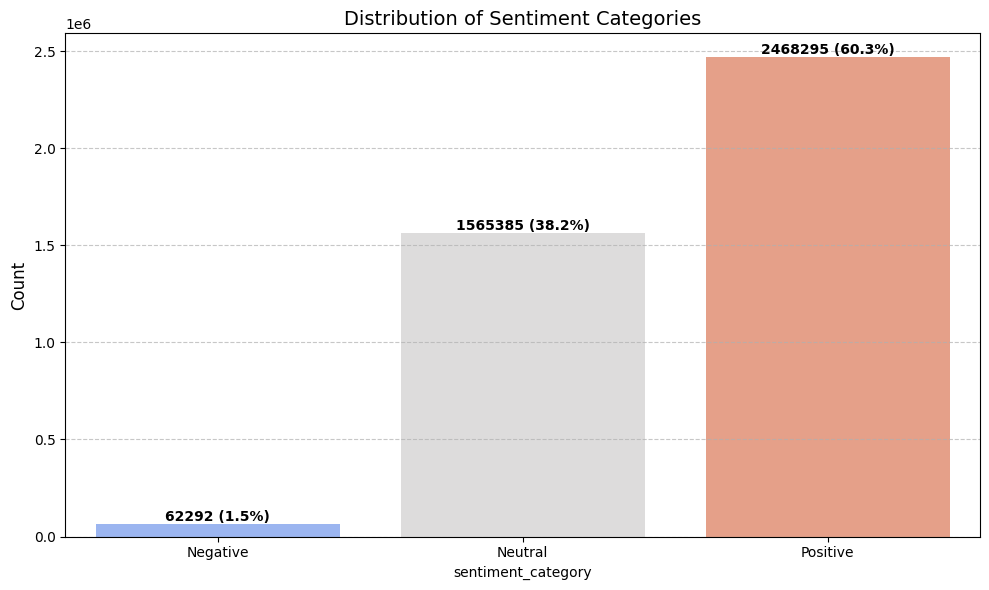

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment_category', y='sentiment_score', data=df, palette="coolwarm", inner='quartile')


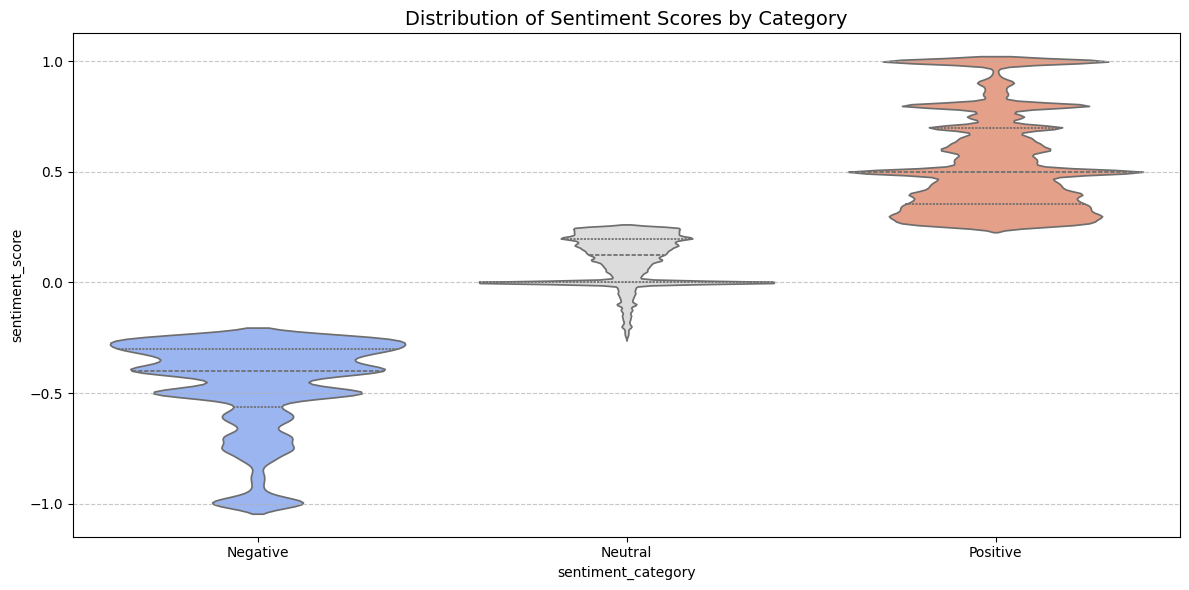

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = df.groupby('sentiment_category')['log_price'].mean().sort_index()
C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="coolwarm")


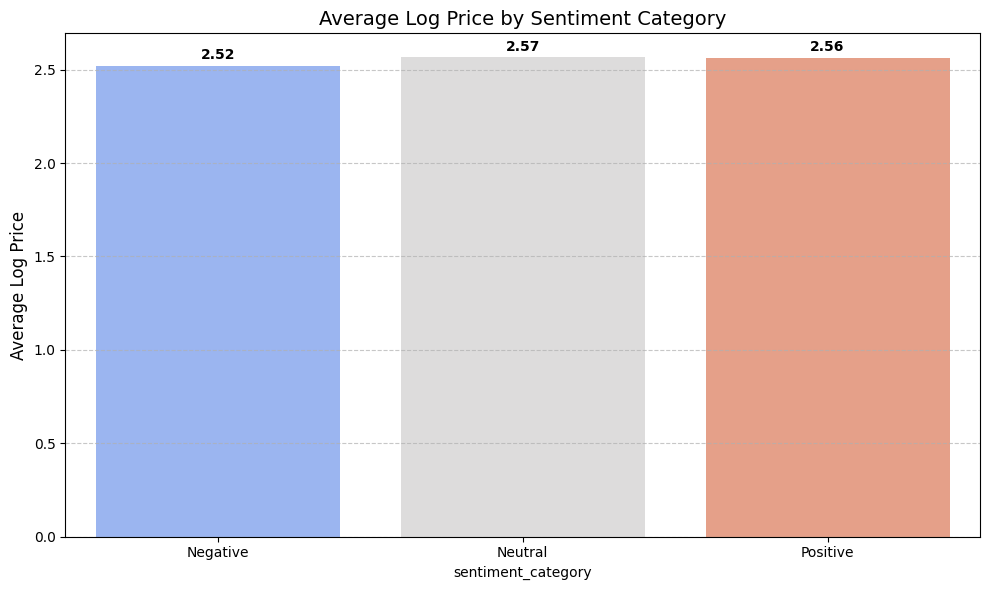

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment_category', y='log_price', data=df, palette="coolwarm", inner='quartile')


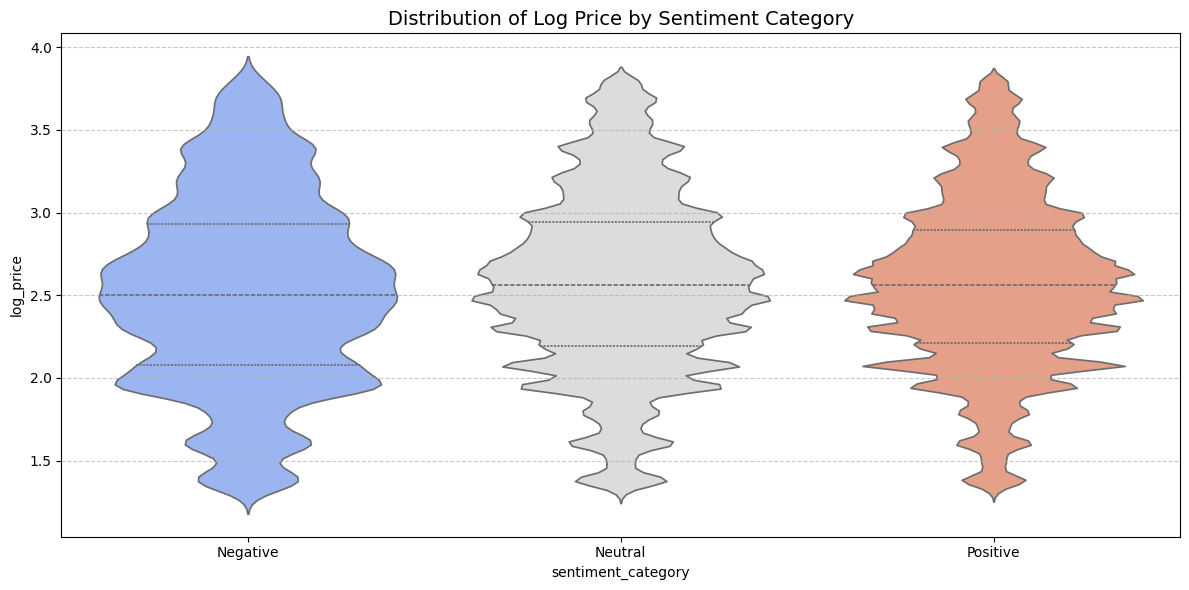

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=domain_sentiment.index, y=domain_sentiment.values, palette="viridis")


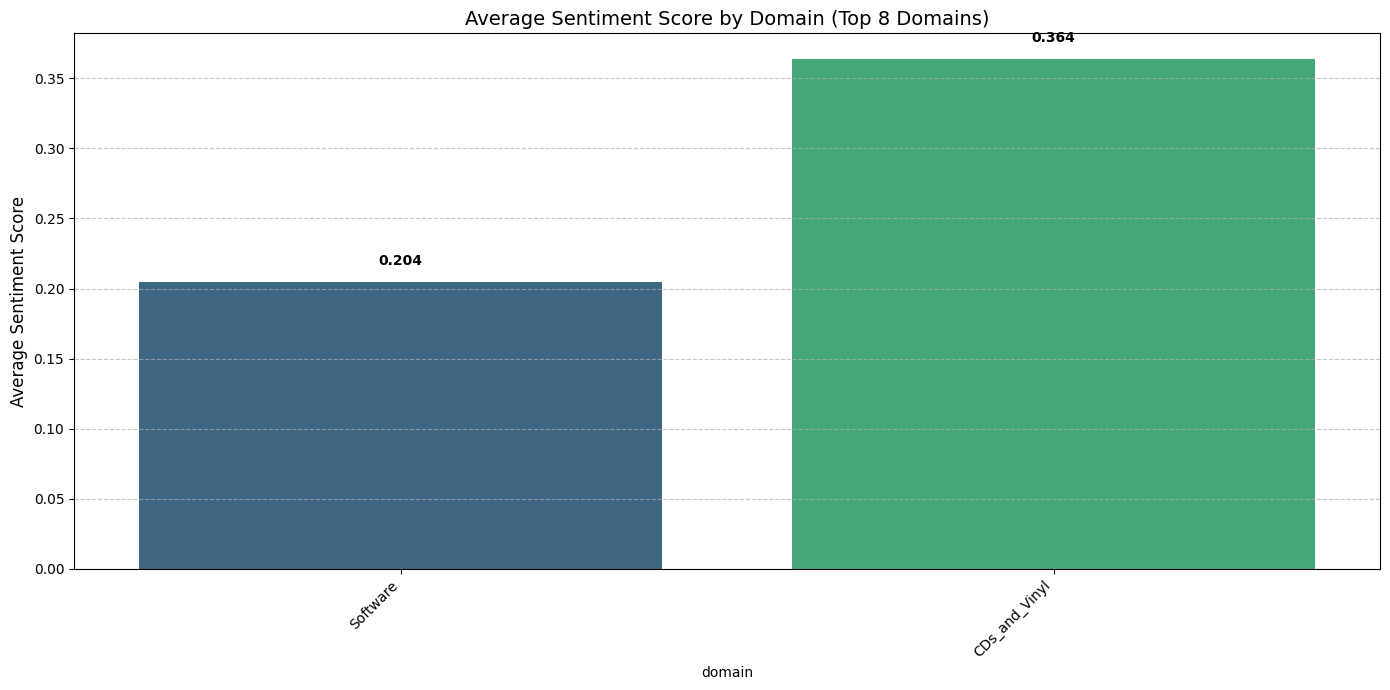

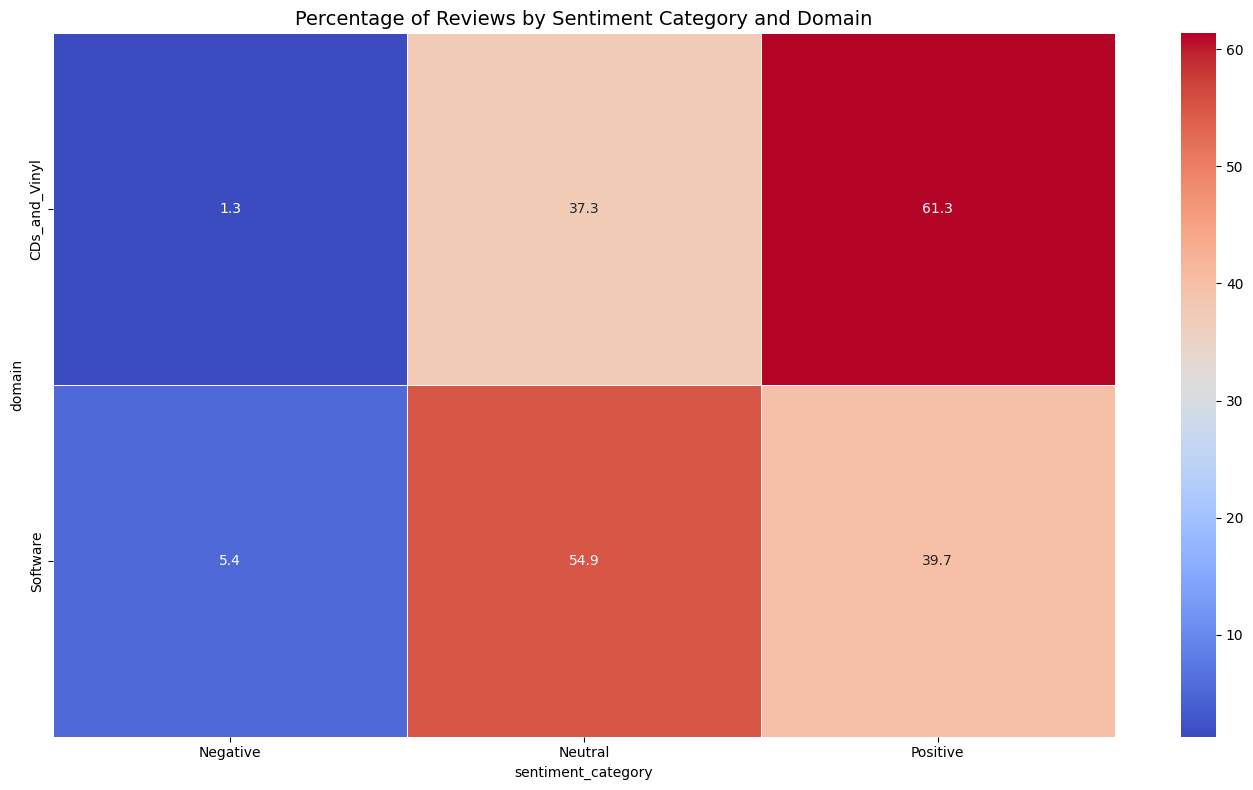

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='sentiment_score', data=df, palette="viridis")


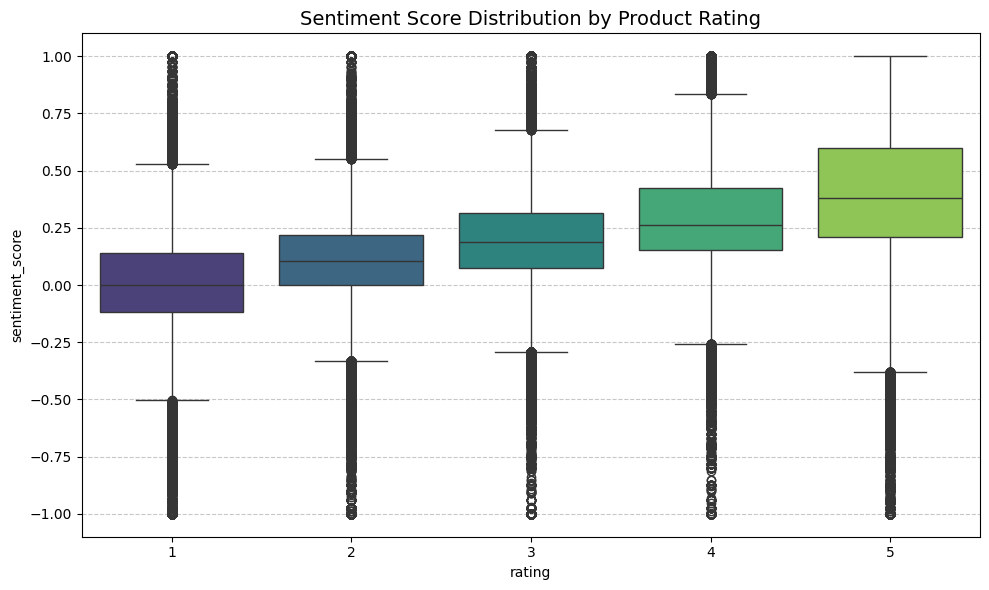


Correlation between Rating and Sentiment Score: 0.3642


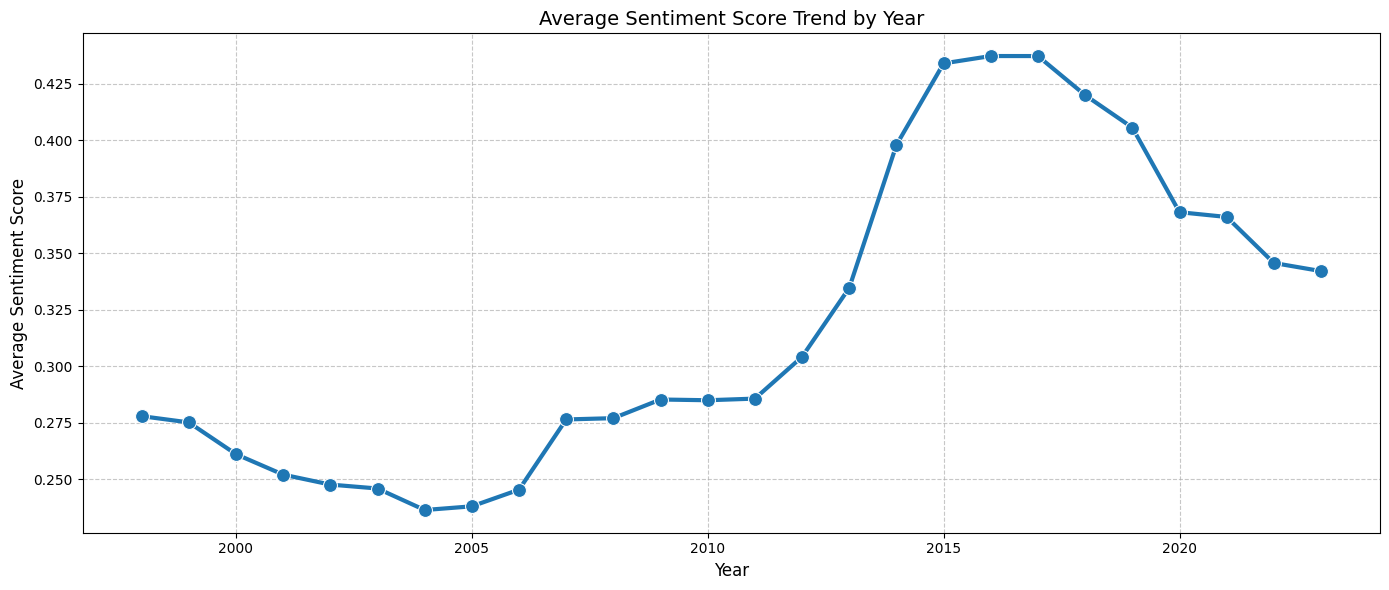

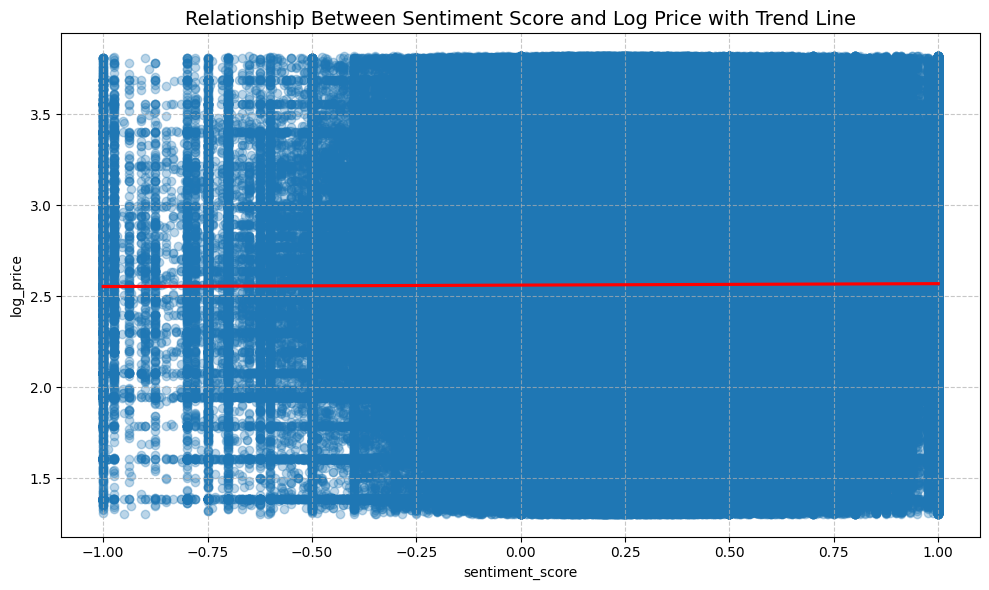


Correlation between Sentiment Score and Log Price: 0.0045

--- Main Category Sentiment Analysis ---
Found 23 main categories in the dataset
Using top 10 categories for visualization


C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_sentiment.index, y=category_sentiment.values, palette="viridis")


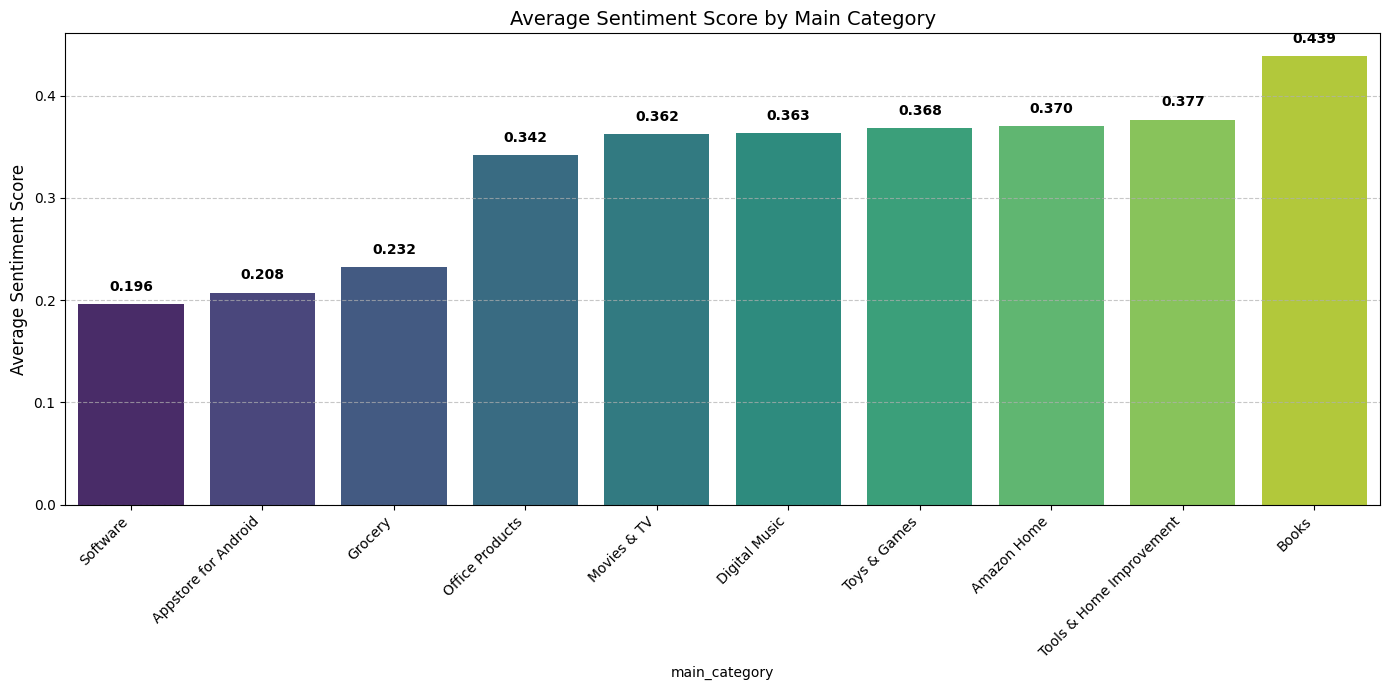

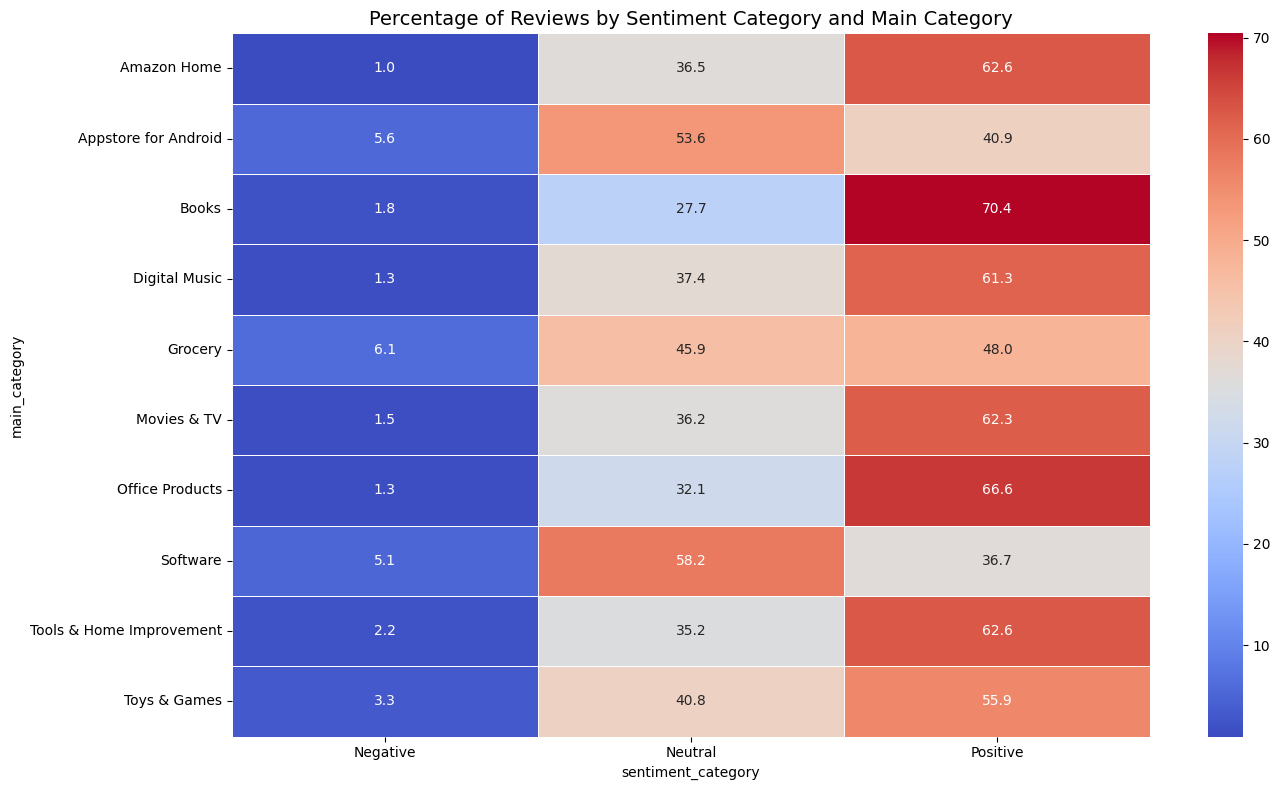

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='main_category', y='sentiment_score', data=category_df, palette="viridis")


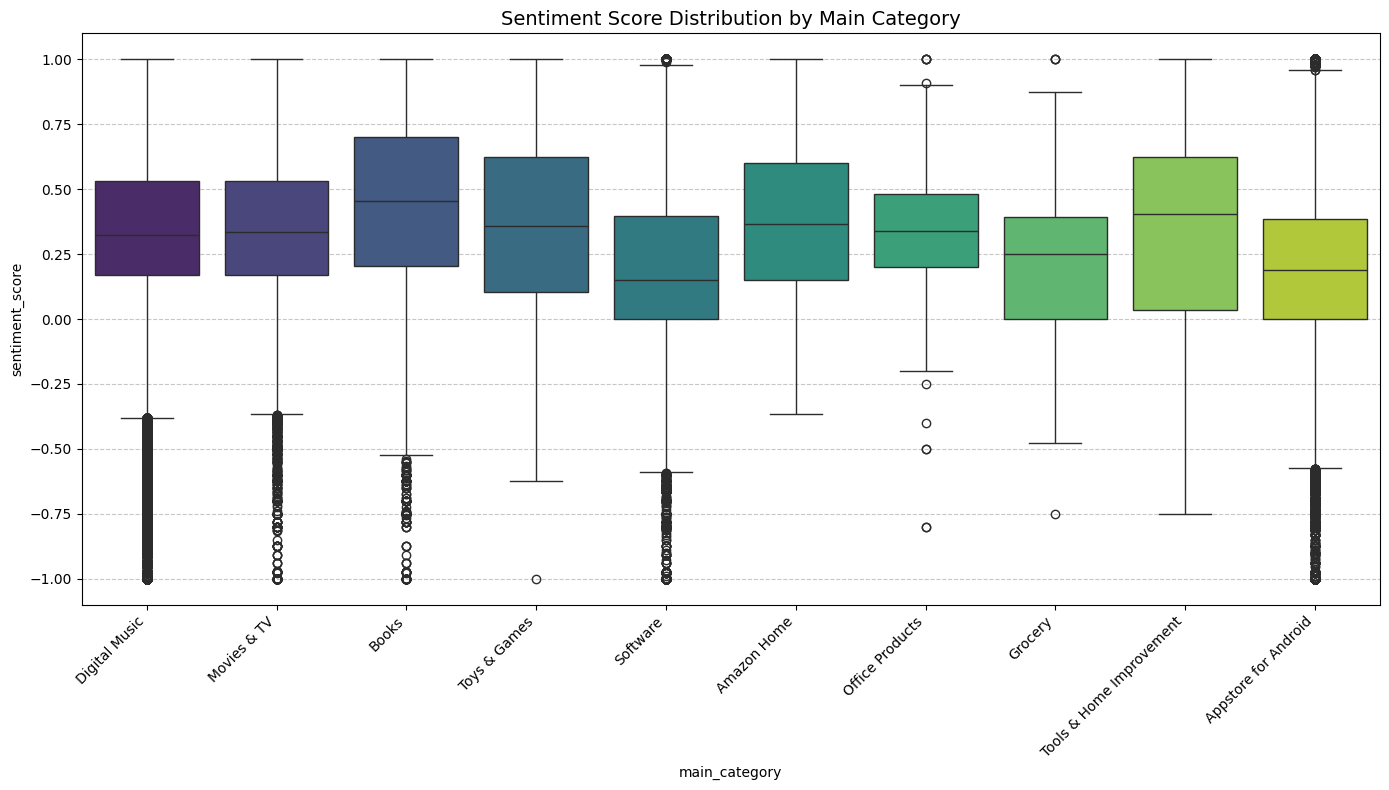

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='main_category', y='sentiment_score', data=category_df, palette="viridis", inner='quartile')


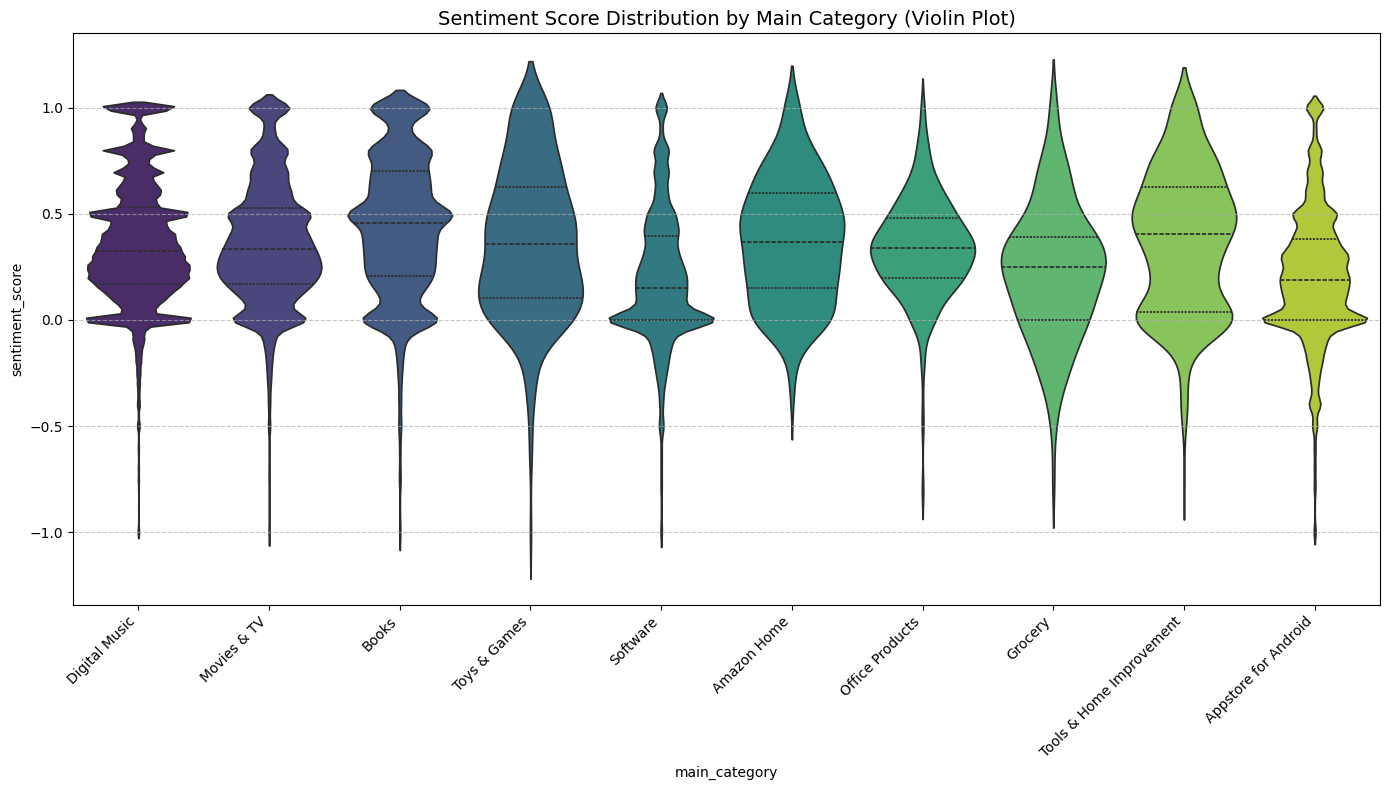

C:\Users\Ahmed Mohamed\AppData\Local\Temp\ipykernel_18932\4171708847.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_category_sentiment = category_df.groupby(['main_category', 'sentiment_category'])['log_price'].mean().unstack()


<Figure size 1400x800 with 0 Axes>

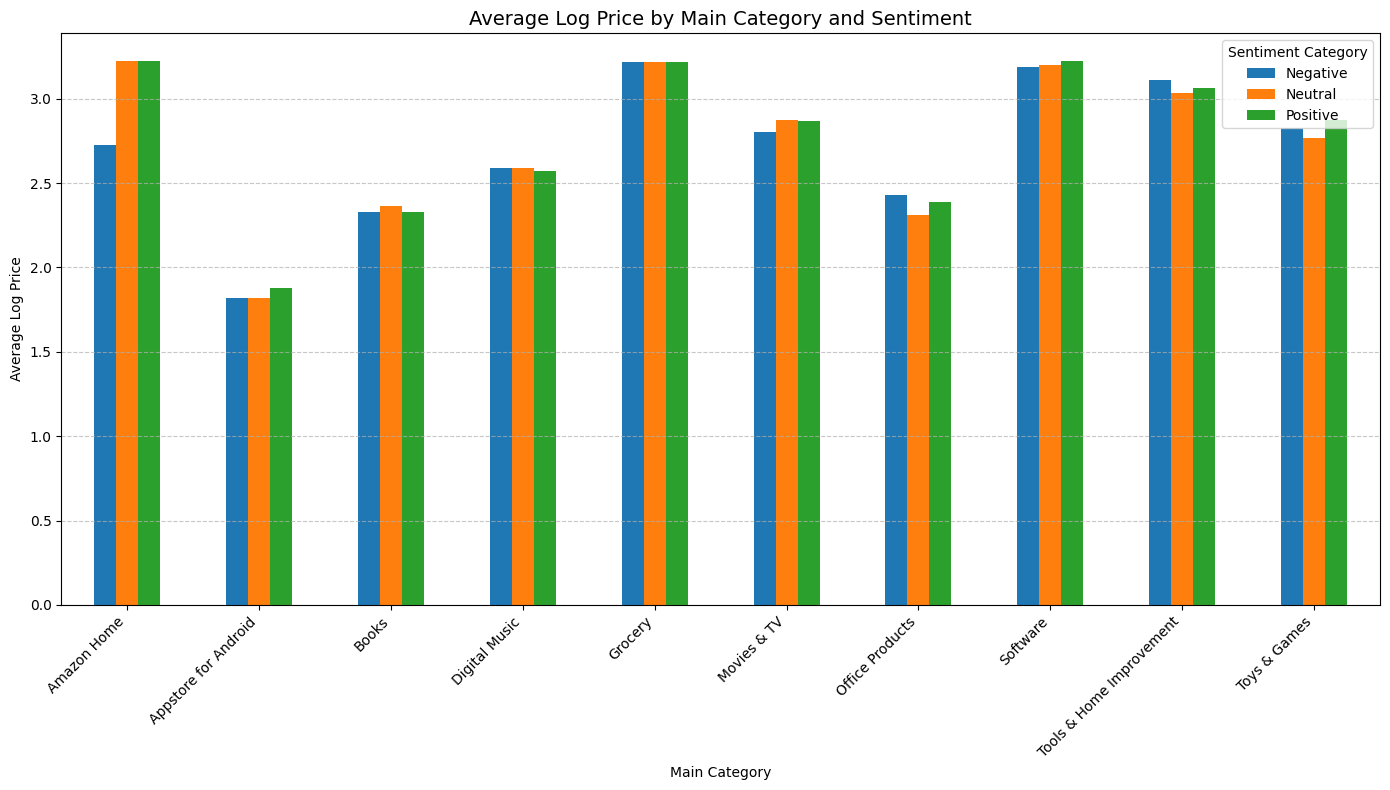


Visualization of sentiment analysis results completed.


In [21]:
# 10. Visualization of Sentiment Analysis Results
def visualize_sentiment_results(df):
    """
    Create various visualizations to analyze sentiment results in relation to other features
    
    Parameters:
        df: DataFrame containing sentiment_score, sentiment_category and other features
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\n--- 10. Visualizing Sentiment Analysis Results ---")
    
    # Check if sentiment data exists
    if 'sentiment_score' not in df.columns or 'sentiment_category' not in df.columns:
        print("Sentiment data not found in dataframe. Please run sentiment analysis first.")
        return
    
    # 1. Bar plot of sentiment distribution
    plt.figure(figsize=(10, 6))
    sentiment_counts = df['sentiment_category'].value_counts().sort_index()
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
    
    # Add value labels on bars
    for i, count in enumerate(sentiment_counts.values):
        ax.text(i, count + 0.1, f"{count} ({count/len(df)*100:.1f}%)", 
                ha='center', va='bottom', fontweight='bold')
    
    plt.title('Distribution of Sentiment Categories', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Violin plot of sentiment scores
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='sentiment_category', y='sentiment_score', data=df, palette="coolwarm", inner='quartile')
    plt.title('Distribution of Sentiment Scores by Category', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Bar plot of average log price by sentiment category (if log_price exists)
    if 'log_price' in df.columns:
        plt.figure(figsize=(10, 6))
        avg_prices = df.groupby('sentiment_category')['log_price'].mean().sort_index()
        ax = sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="coolwarm")
        
        # Add value labels on bars
        for i, price in enumerate(avg_prices.values):
            ax.text(i, price + 0.02, f"{price:.2f}", ha='center', va='bottom', fontweight='bold')
        
        plt.title('Average Log Price by Sentiment Category', fontsize=14)
        plt.ylabel('Average Log Price', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 4. Violin plot of log price by sentiment category
        plt.figure(figsize=(12, 6))
        sns.violinplot(x='sentiment_category', y='log_price', data=df, palette="coolwarm", inner='quartile')
        plt.title('Distribution of Log Price by Sentiment Category', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # 5. Domain-specific sentiment analysis (if domain exists)
    if 'domain' in df.columns:
        # Select top domains by count for readability
        top_domains = df['domain'].value_counts().nlargest(8).index.tolist()
        domain_df = df[df['domain'].isin(top_domains)].copy()
        
        # Bar plot of average sentiment by domain
        plt.figure(figsize=(14, 7))
        domain_sentiment = domain_df.groupby('domain')['sentiment_score'].mean().sort_values()
        ax = sns.barplot(x=domain_sentiment.index, y=domain_sentiment.values, palette="viridis")
        
        # Add value labels
        for i, score in enumerate(domain_sentiment.values):
            ax.text(i, score + 0.01, f"{score:.3f}", ha='center', va='bottom', fontweight='bold')
        
        plt.title('Average Sentiment Score by Domain (Top 8 Domains)', fontsize=14)
        plt.ylabel('Average Sentiment Score', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Heatmap of sentiment categories by domain
        plt.figure(figsize=(14, 8))
        domain_sentiment_counts = pd.crosstab(domain_df['domain'], domain_df['sentiment_category'], normalize='index') * 100
        sns.heatmap(domain_sentiment_counts, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)
        plt.title('Percentage of Reviews by Sentiment Category and Domain', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # 6. Rating vs. Sentiment correlation (if rating exists)
    if 'rating' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='rating', y='sentiment_score', data=df, palette="viridis")
        plt.title('Sentiment Score Distribution by Product Rating', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Calculate correlation
        rating_sentiment_corr = df[['rating', 'sentiment_score']].corr().iloc[0, 1]
        print(f"\nCorrelation between Rating and Sentiment Score: {rating_sentiment_corr:.4f}")
    
    # 7. Time analysis (if timestamp exists)
    if 'timestamp' in df.columns:
        try:
            # Convert to datetime if not already
            if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            
            # Extract year and create yearly sentiment trends
            df['year'] = df['timestamp'].dt.year
            
            # Filter years with sufficient data
            year_counts = df['year'].value_counts()
            valid_years = year_counts[year_counts > 30].index.tolist()
            
            if valid_years:
                yearly_df = df[df['year'].isin(valid_years)].copy()
                
                plt.figure(figsize=(14, 6))
                yearly_sentiment = yearly_df.groupby('year')['sentiment_score'].mean()
                sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment.values, marker='o', linewidth=3, markersize=10)
                
                plt.title('Average Sentiment Score Trend by Year', fontsize=14)
                plt.ylabel('Average Sentiment Score', fontsize=12)
                plt.xlabel('Year', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Error in time analysis: {e}")
            
    # 8. Scatter plot of sentiment vs. log_price with regression line
    if 'log_price' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.regplot(x='sentiment_score', y='log_price', data=df, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
        plt.title('Relationship Between Sentiment Score and Log Price with Trend Line', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Calculate correlation
        sentiment_price_corr = df[['sentiment_score', 'log_price']].corr().iloc[0, 1]
        print(f"\nCorrelation between Sentiment Score and Log Price: {sentiment_price_corr:.4f}")
    
    # 9. Main Category Analysis (new section)
    if 'main_category' in df.columns:
        print("\n--- Main Category Sentiment Analysis ---")
        
        # Count number of categories
        num_categories = df['main_category'].nunique()
        print(f"Found {num_categories} main categories in the dataset")
        
        # Select top categories by count for readability
        if num_categories > 10:
            top_categories = df['main_category'].value_counts().nlargest(10).index.tolist()
            category_df = df[df['main_category'].isin(top_categories)].copy()
            print(f"Using top 10 categories for visualization")
        else:
            category_df = df.copy()
            top_categories = df['main_category'].unique().tolist()
        
        # 9.1 Bar plot of average sentiment by main category
        plt.figure(figsize=(14, 7))
        category_sentiment = category_df.groupby('main_category')['sentiment_score'].mean().sort_values()
        ax = sns.barplot(x=category_sentiment.index, y=category_sentiment.values, palette="viridis")
        
        # Add value labels
        for i, score in enumerate(category_sentiment.values):
            ax.text(i, score + 0.01, f"{score:.3f}", ha='center', va='bottom', fontweight='bold')
        
        plt.title('Average Sentiment Score by Main Category', fontsize=14)
        plt.ylabel('Average Sentiment Score', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 9.2 Heatmap of sentiment categories by main category
        plt.figure(figsize=(14, 8))
        category_sentiment_counts = pd.crosstab(category_df['main_category'], category_df['sentiment_category'], normalize='index') * 100
        sns.heatmap(category_sentiment_counts, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5)
        plt.title('Percentage of Reviews by Sentiment Category and Main Category', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # 9.3 Box plot of sentiment scores by main category
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='main_category', y='sentiment_score', data=category_df, palette="viridis")
        plt.title('Sentiment Score Distribution by Main Category', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 9.4 Violin plot of sentiment scores by main category
        plt.figure(figsize=(14, 8))
        sns.violinplot(x='main_category', y='sentiment_score', data=category_df, palette="viridis", inner='quartile')
        plt.title('Sentiment Score Distribution by Main Category (Violin Plot)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 9.5 Average price by main category and sentiment
        if 'log_price' in df.columns:
            # Calculate average log price for each combination
            avg_price_by_category_sentiment = category_df.groupby(['main_category', 'sentiment_category'])['log_price'].mean().unstack()
            
            # Plot stacked bar chart
            plt.figure(figsize=(14, 8))
            avg_price_by_category_sentiment.plot(kind='bar', stacked=False, figsize=(14, 8))
            plt.title('Average Log Price by Main Category and Sentiment', fontsize=14)
            plt.xlabel('Main Category')
            plt.ylabel('Average Log Price')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend(title='Sentiment Category')
            plt.tight_layout()
            plt.show()
    
    print("\nVisualization of sentiment analysis results completed.")

# Call the visualization function with the sentiment analysis results
visualize_sentiment_results(final_sentiment_df)

In [27]:
print("\n--- Final Clean Dataset Overview ---")
print(f"Dataset shape: {final_sentiment_df.shape}")

# Unique counts
summary_cols = ['parent_asin', 'asin', 'rating', 'timestamp', 'main_category',
                'price', 'log_price', 'domain', 'sentiment_score', 
                'sentiment_category', 'year']

for col in summary_cols:
    unique_count = final_sentiment_df[col].nunique()
    print(f"Number of unique {col.replace('_', ' ')}s: {unique_count}")

# Value counts
print("\n--- Distribution Summaries ---")
dist_cols = ['rating', 'sentiment_category', 'sentiment_score', 'log_price', 
             'main_category', 'domain', 'year']

for col in dist_cols:
    print(f"\nDistribution for {col.replace('_', ' ')}:\n{final_sentiment_df[col].value_counts().sort_index()}")

# Top products by review count
print("\n--- Top 10 Products by Review Count ---")
print(final_sentiment_df['asin'].value_counts().head(10))

# Top categories by number of reviews
print("\n--- Top 5 Main Categories ---")
print(final_sentiment_df['main_category'].value_counts().head(5))

# Review volume per year
print("\n--- Reviews per Year ---")
print(final_sentiment_df['year'].value_counts().sort_index())



--- Final Clean Dataset Overview ---
Dataset shape: (4095972, 13)
Number of unique parent asins: 455999
Number of unique asins: 456191
Number of unique ratings: 5
Number of unique timestamps: 4031765
Number of unique main categorys: 23
Number of unique prices: 4188
Number of unique log prices: 4188
Number of unique domains: 2
Number of unique sentiment scores: 678149
Number of unique sentiment categorys: 3
Number of unique years: 27

--- Distribution Summaries ---

Distribution for rating:
rating
1     180246
2     123092
3     243731
4     567094
5    2981809
Name: count, dtype: int64

Distribution for sentiment category:
sentiment_category
Negative      62292
Neutral     1565385
Positive    2468295
Name: count, dtype: int64

Distribution for sentiment score:
sentiment_score
-1.000000      3188
-1.000000        11
-0.991667         1
-0.988281        10
-0.987500        25
              ...  
 0.994141         8
 0.995313         2
 0.996094         1
 0.996705         1
 1.000000   

In [28]:
final_sentiment_df.head(10)

parent_asin        asin  rating           timestamp  \
0  B000000LWZ  B000000LWZ       5 1997-09-09 03:13:17   
1  B000002H3Z  B000002H3Z       5 1997-09-13 22:05:50   
2  B000003YSX  B000003YSX       5 1997-10-05 21:21:20   
3  B000002H2H  B000002H2H       5 1997-10-20 14:48:57   
4  B000002AS3  B000002AS3       5 1997-10-21 17:42:32   
5  B000005EAP  B000005EAP       5 1997-11-08 22:42:01   
6  B000002B6Z  B000002B6Z       5 1997-11-12 01:37:58   
7  B00000150Q  B00000150Q       5 1997-11-14 03:47:57   
8  B000002GP1  B000002GP1       5 1997-11-18 06:54:25   
9  B000005ALT  B000005ALT       5 1997-11-18 21:23:34   

                                                text  main_category  price  \
0  It was while driving on Highway 83, heading of...  Digital Music  10.98   
1  This isn't actually a book. It is a beautifull...  Digital Music  14.98   
2  This album is not of what one would usually re...  Digital Music  15.99   
3  Released on November 23 1984, Metallica's seco...  Digital Music   7.30   
4  This is the first cd made by Oasis. My favorit...  Digital Music   9.09   
5  As a world premier, this CD's creators were na...  Digital Music  31.90   
6  If you don't know Alice Cooper music, this is ...  Digital Music  11.95   
7  This Cd is very well put together and has a ni...  Digital Music  14.99   
8  &quot;Lock 'N Load&quot; is Denis Leary's seco...  Digital Music   7.77   
9  Yes, RENT IS the simply the best Musical out t...  Digital Music  15.99   

   log_price         domain  sentiment_score sentiment_category  year  \
0   2.396075  CDs_and_Vinyl         0.256641           Positive  1997   
1   2.706716  CDs_and_Vinyl         0.620000           Positive  1997   
2   2.771964  CDs_and_Vinyl         0.113333            Neutral  1997   
3   1.987874  CDs_and_Vinyl         0.149953            Neutral  1997   
4   2.207175  CDs_and_Vinyl         0.417614           Positive  1997   
5   3.462606  CDs_and_Vinyl         0.560714           Positive  1997   
6   2.480731  CDs_and_Vinyl         0.550000           Positive  1997   
7   2.707383  CDs_and_Vinyl         0.400000           Positive  1997   
8   2.050270  CDs_and_Vinyl         0.262857           Positive  1997   
9   2.771964  CDs_and_Vinyl         0.153306            Neutral  1997   

   text_length  
0         1029  
1          337  
2          754  
3         1289  
4          179  
5         1092  
6          452  
7          143  
8          560  
9          553

In [26]:
final_sentiment_df.columns

Index(['parent_asin', 'asin', 'rating', 'timestamp', 'text', 'main_category',
       'price', 'log_price', 'domain', 'sentiment_score', 'sentiment_category',
       'year', 'text_length'],
      dtype='object')

In [29]:
final_sentiment_df.to_csv(r"D:\Desktop Codes Data\Data Science\Developement\ipynb files\Sales_Forcast_Project\Developement\Processing and Modeling\data_set.csv", index=False)
